
# Biostat 682 — Lecture 11: Beyond Linear Regression (PyMC Edition)


This notebook fit the following Bayesian models **PyMC**:

- Random Intercept (two-way random effects)
- Random Slope (varying intercepts & slopes)
- Bayesian Semiparametric Regression (splines)
- Gaussian Process Regression
- Bayesian Logistic Regression

Each section offers **data-loading cells** that try to load your actual data. If not present, synthetic data with similar structure is generated so the code remains runnable.


In [1]:

# If needed in a fresh environment, uncomment to install
# !pip install pymc arviz pandas numpy patsy matplotlib scikit-learn

import numpy as np
import pandas as pd
import patsy as pt
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

from pathlib import Path

RANDOM_SEED = 68211
rng = np.random.default_rng(RANDOM_SEED)
az.rcParams["stats.hdi_prob"] = 0.95
plt.rcParams.update({"figure.figsize": (6,4), "axes.grid": True})


/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:345: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# After running, click the link, authorize, and paste the code.
# Your Drive will now be accessible under /content/drive/MyDrive/

# === Set your project path ===
projpath = "/content/drive/MyDrive/ColabNotebooks/Biostat682_Fall2025/data/"  # <-- update this folder



Mounted at /content/drive


In [3]:

def plot_with_band(x, med, lo, hi, title="", xlabel="", ylabel=""):
    plt.figure()
    plt.plot(x, med)
    plt.fill_between(x, lo, hi, alpha=0.25)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()



## Data Paths

Adjust these paths to your local files if you have them exported as CSV/NPZ:

- Ozone (two-way RE): `Ozone_levels.csv` (wide matrix `Y` with shape `[ns, nt]`) and `locations.csv` with columns `x,y` (for plotting)  
- Bone density (random slope): `bone_density.csv` with columns: `id, age, y` (four repeated measures per subject)  
- mcycle (splines & GP): `mcycle.csv` with columns: `times, accel`  
- Spambase (logistic): `spambase.csv` with columns: `is_spam, word_freq_free, word_freq_make` (rename to lower snake case if needed)

If files are missing, synthetic data will be generated.


## Random Intercept (Two-Way Random Effects): Data

[[25.375 32.125 36.875 ... 33.125 36.625 39.125]
 [62.375 65.5   72.75  ... 59.125 64.875 71.25 ]
 [54.375 46.5   47.75  ... 62.5   76.875 65.875]
 ...
 [28.75  31.5   40.375 ... 47.25  41.125 38.125]
 [48.25  52.875 38.625 ... 39.25  58.875 41.5  ]
 [68.875 52.375 56.875 ... 57.286 48.875 50.125]]
Loaded Ozone Y: (100, 31)


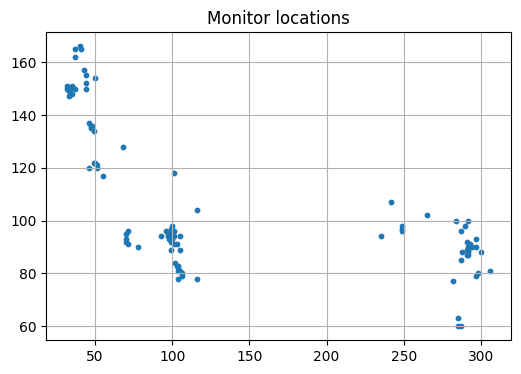

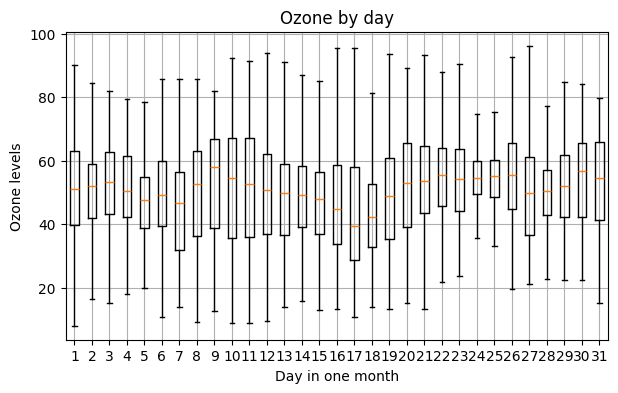

In [4]:

# Try to load Ozone Y matrix and locations
ozone_Y_path = projpath + "Ozone_levels.csv"
ozone_loc_path = projpath + "locations.csv"


Y = pd.read_csv(ozone_Y_path).to_numpy()
ns, nt = Y.shape
print(Y)
print("Loaded Ozone Y:", Y.shape)
s = pd.read_csv(ozone_loc_path).to_numpy()

# Quick visuals
plt.figure()
plt.scatter(s[:min(ns,100),0], s[:min(ns,100),1], s=10)
plt.title("Monitor locations")
plt.show()

Y_clean = np.where(np.isnan(Y), np.nanmean(Y, axis=0), Y)
plt.figure(figsize=(7,4))
plt.boxplot(Y_clean, showfliers=False)
plt.xlabel("Day in one month")
plt.ylabel("Ozone levels")
plt.title("Ozone by day")
plt.show()


### Model & PyMC fit

In [5]:

with pm.Model() as ozone_re:
    mu = pm.Normal("mu", 0.0, 10.0)
    sigma_e = pm.HalfNormal("sigma_e", 10.0)
    sigma_s = pm.HalfNormal("sigma_s", 10.0)
    sigma_t = pm.HalfNormal("sigma_t", 10.0)

    alpha = pm.Normal("alpha", 0.0, sigma_s, shape=Y.shape[0])  # site
    gamma = pm.Normal("gamma", 0.0, sigma_t, shape=Y.shape[1])  # day

    mean = mu + alpha[:, None] + gamma[None, :]
    y_obs = pm.Normal("y_obs", mu=mean, sigma=sigma_e, observed=Y)

    idata_oz = pm.sample(random_seed=RANDOM_SEED, chains=2, target_accept=0.9)

az.summary(idata_oz, var_names=["mu","sigma_e","sigma_s","sigma_t"]).round(3)


/usr/local/lib/python3.12/dist-packages/pymc/model/core.py:1319: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,50.151,1.272,47.736,52.794,0.095,0.047,184.0,295.0,1.01
sigma_e,13.533,0.191,13.174,13.898,0.003,0.005,3775.0,1458.0,1.00
sigma_s,12.045,0.948,10.176,13.897,0.018,0.024,2756.0,1251.0,1.00
sigma_t,3.132,0.517,2.280,4.185,0.012,0.014,2107.0,1567.0,1.00


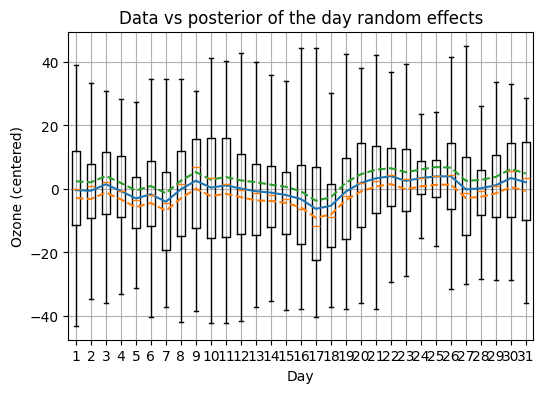

In [6]:

# Compare centered data vs posterior for day effects (gamma)
R = Y_clean - Y_clean.mean()

post = idata_oz.posterior
g = post["gamma"].stack(sample=("chain","draw")).values
g_med = np.median(g, axis=1)
g_lo = np.quantile(g, 0.025, axis=1)
g_hi = np.quantile(g, 0.975, axis=1)


plt.figure()
plt.boxplot(R, showfliers=False)
plt.plot(range(1, Y.shape[1]+1), g_med, linestyle='-')
plt.plot(range(1, Y.shape[1]+1), g_lo, linestyle='--')
plt.plot(range(1, Y.shape[1]+1), g_hi, linestyle='--')
plt.title("Data vs posterior of the day random effects")
plt.xlabel("Day")
plt.ylabel("Ozone (centered)")
plt.show()


## Random Slope Model: Data

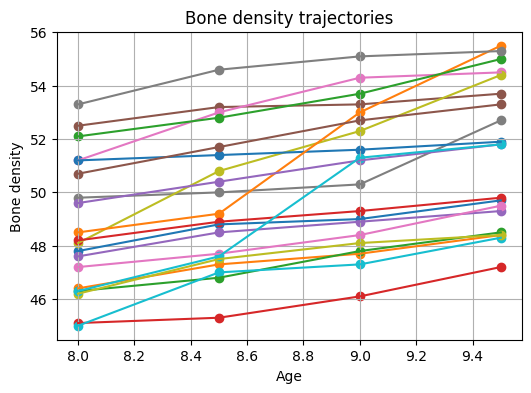

In [7]:

bone_path = projpath + "bone_density.csv"

df_bone = pd.read_csv(bone_path)
# Expect columns: id, age, y (long format)


# Quick plot (each subject)
for sid, g in df_bone.groupby("id"):
    plt.plot(g["age"], g["y"])
    plt.scatter(g["age"], g["y"])
plt.xlabel("Age")
plt.ylabel("Bone density")
plt.title("Bone density trajectories")
plt.show()

# Prepare for modeling
ids = df_bone["id"].astype(int).to_numpy()
age_vec = df_bone["age"].to_numpy()
y_vec = df_bone["y"].to_numpy()
N = ids.max() + 1


### Model & PyMC fit

In [8]:
with pm.Model() as rs_mod:
    # Population intercept & slope hyperpriors
    mu_beta = pm.Normal("mu_beta", mu=np.zeros(2), sigma=10.0, shape=2)

    # Random effects covariance via LKJ
    sd_dist = pm.HalfNormal.dist(1.0, shape=2)
    chol, corr, sigmas_tt = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist, compute_corr=True)
    # Subject-specific intercept/slope
    z = pm.Normal("z", 0.0, 1.0, shape=(N, 2))
    u = pm.Deterministic("u", mu_beta + pm.math.dot(z, chol.T))  # (N,2)

    sigma = pm.HalfNormal("sigma", 1.0)
    mu = u[ids, 0] + u[ids, 1] * age_vec
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_vec)

    idata_rs = pm.sample(random_seed=RANDOM_SEED,draws=5000, chains=3, target_accept=0.95)

az.summary(idata_rs, var_names=["mu_beta","sigma"]).round(3)

Output()

ERROR:pymc.stats.convergence:There were 55 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta[0],33.048,1.469,30.191,35.892,0.013,0.012,12244.0,10393.0,1.0
mu_beta[1],1.944,0.177,1.605,2.299,0.002,0.001,10693.0,9614.0,1.0
sigma,0.820,0.082,0.666,0.985,0.001,0.001,8052.0,7729.0,1.0


In [9]:

# Posterior of subject-specific predicted value at age = max observed
age_star = df_bone["age"].max()
post = idata_rs.posterior
u_draws = post["u"].stack(sample=("chain","draw")).values  # (N,2,S)
u_med = np.median(u_draws, axis=2)
pred = u_med[:,0] + u_med[:,1] * age_star

# Compare observed vs predicted at last visit if available
obs = df_bone[df_bone["age"]==age_star].sort_values("id")["y"].to_numpy()
if obs.shape[0] == pred.shape[0]:
    plt.figure()
    plt.scatter(obs, pred)
    plt.plot([obs.min(), obs.max()], [obs.min(), obs.max()])
    plt.xlabel("Observation at last visit")
    plt.ylabel("Predicted at last visit (posterior median)")
    plt.title("Obs. vs Pred.")
    plt.show()


## Bayesian Semiparametric Regression (Splines): Data

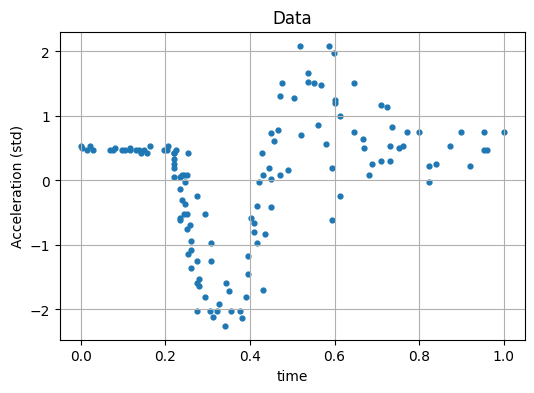

In [10]:

mcycle_path = projpath + "mcycle.csv"
mcy = pd.read_csv(mcycle_path)
X = mcy["times"].to_numpy().astype(float)
Y = mcy["accel"].to_numpy().astype(float)

# Standardize like the R notebook
Y = (Y - Y.mean())/Y.std()
X = (X - X.min())/(X.max()-X.min())

plt.figure()
plt.scatter(X, Y, s=12)
plt.xlabel("time")
plt.ylabel("Acceleration (std)")
plt.title("Data")
plt.show()


### Spline Basis & PyMC fit

Output()

Output()

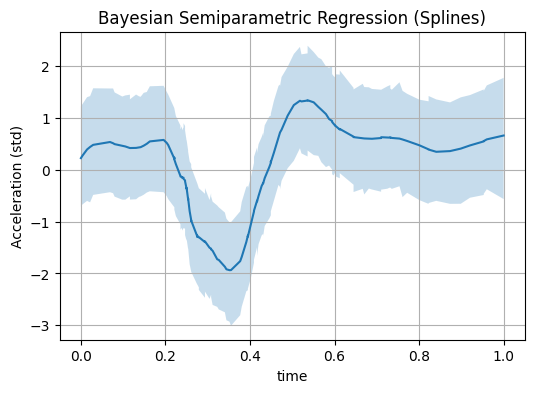

In [11]:
from patsy import bs

J = 20
B = bs(X, df=J, include_intercept=False)
B = np.asarray(B)

with pm.Model() as spl_mod:
    mu0 = pm.Normal("mu0", 0.0, 10.0)
    tau_b = pm.HalfNormal("tau_b", 1.0)
    beta = pm.Normal("beta", 0.0, tau_b, shape=J)
    sigma = pm.HalfNormal("sigma", 1.0)

    mean = mu0 + pm.math.dot(B, beta)
    y_obs = pm.Normal("y_obs", mu=mean, sigma=sigma, observed=Y)

    idata_spl = pm.sample(random_seed=RANDOM_SEED, chains=2, target_accept=0.9)

# Sample from the posterior predictive distribution
with spl_mod:
    ppc_spl = pm.sample_posterior_predictive(idata_spl, var_names=["y_obs"], extend_inferencedata=True, random_seed=RANDOM_SEED)

post = ppc_spl.posterior_predictive
m = post["y_obs"].stack(sample=("chain","draw")).mean("sample").values
hdi = az.hdi(post, var_names=["y_obs"])["y_obs"].to_numpy()
plot_with_band(X, m, hdi[:,0], hdi[:,1], title="Bayesian Semiparametric Regression (Splines)",
               xlabel="time", ylabel="Acceleration (std)")

## Gaussian Process Regression (GP)

Output()

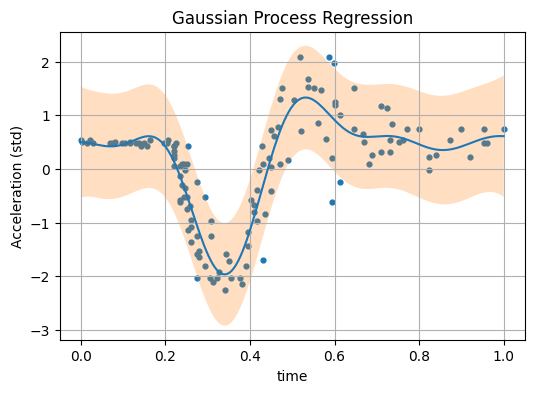

In [13]:
x_grid = np.linspace(0, 1, 200)[:, None]
X1 = X.reshape(-1, 1)

with pm.Model() as gp_mod:
    ell  = pm.Gamma("ell", alpha=2.0, beta=6.0)  # length-scale
    eta  = pm.HalfNormal("eta", 1.0)             # signal SD
    cov  = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    gp   = pm.gp.Marginal(cov_func=cov)
    sigma = pm.HalfNormal("sigma", 0.5)
    y_ = gp.marginal_likelihood("y", X=X1, y=Y, sigma=sigma)

    idata_gp = pm.sample(random_seed=RANDOM_SEED, chains=2, target_accept=0.9)

# Use posterior means as a plug-in point
ell_hat   = float(idata_gp.posterior["ell"].mean())
eta_hat   = float(idata_gp.posterior["eta"].mean())
sigma_hat = float(idata_gp.posterior["sigma"].mean())

with pm.Model():
    cov_hat = (eta_hat**2) * pm.gp.cov.ExpQuad(1, ls=ell_hat)
    gp_hat  = pm.gp.Marginal(cov_func=cov_hat)
     # Attach training data & fixed noise so the GP caches the required terms
    y_like = gp_hat.marginal_likelihood("y", X=X1, y=Y, sigma=sigma_hat)

    # Predictive mean/var using fixed hyperparameters
    f_mean, f_var = gp_hat.predict(Xnew=x_grid,diag=True, pred_noise=True)

f_sd = np.sqrt(f_var)

plt.figure()
plt.scatter(X, Y, s=12)
plt.plot(x_grid.ravel(), f_mean)
plt.fill_between(x_grid.ravel(), f_mean - 1.96*f_sd, f_mean + 1.96*f_sd, alpha=0.25)
plt.title("Gaussian Process Regression")
plt.xlabel("time"); plt.ylabel("Acceleration (std)")
plt.show()

## Bayesian Logistic Regression (Spambase subset): Data

In [14]:

sp_path = projpath + "spambase.csv"
sp = pd.read_csv(sp_path)

# Expect columns: is_spam, word_freq_free, word_freq_make (case-insensitive is ok)
cols = {c.lower(): c for c in sp.columns}
y = sp[cols.get("is.spam","is.spam")]
X = sp[[cols.get("word.freq.free","word.freq.free"),
        cols.get("word.freq.make","word.freq.make")]].copy()

# Train/test split
n = len(y)
idx = rng.permutation(n)
train = idx[:1000]
test = idx[1000:1100]

X_train = X.iloc[train].to_numpy()
y_train = y.iloc[train].to_numpy() if hasattr(y, "iloc") else y[train]
X_test = X.iloc[test].to_numpy()
y_test = y.iloc[test].to_numpy() if hasattr(y, "iloc") else y[test]

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (1000, 2)  Test size: (100, 2)


### PyMC fit and baseline comparisons

In [16]:

with pm.Model() as logit_mod:
    beta0 = pm.Normal("beta0", 0.0, 10.0)
    beta = pm.Normal("beta", 0.0, 5.0, shape=X_train.shape[1])
    eta = beta0 + pm.math.dot(X_train, beta)
    p = pm.math.sigmoid(eta)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)
    idata_logit = pm.sample(random_seed=RANDOM_SEED, chains=2, target_accept=0.9)

# Predict on test set
post = idata_logit.posterior
b0 = post["beta0"].stack(sample=("chain","draw")).values
b = post["beta"].stack(sample=("chain","draw")).values   # shape: (p, S)
eta_test = b0[None, :] + X_test @ b
p_test = 1/(1+np.exp(-eta_test))
y_pred = (p_test.mean(axis=1) > 0.5).astype(int)

bayes_acc = (y_pred == y_test).mean()

# Baselines: GLM and RandomForest if available
glm_acc = np.nan
rf_acc = np.nan
try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    glm = LogisticRegression(max_iter=200).fit(X_train, y_train)
    glm_acc = glm.score(X_test, y_test)
    rf = RandomForestClassifier(n_estimators=500, random_state=RANDOM_SEED).fit(X_train, y_train)
    rf_acc = rf.score(X_test, y_test)
except Exception as e:
    print("Baseline models not available:", e)

pd.Series({
    "BayesLogit": float(bayes_acc),
    "GLM": None if np.isnan(glm_acc) else float(glm_acc),
    "RF": None if np.isnan(rf_acc) else float(rf_acc),
})


Output()

,0
BayesLogit,0.73
GLM,0.73
RF,0.75
